tensor core is not the right approach in this workflow

Initializing CUDA...
CUDA initialization complete
Function signatures configured
Blur Tensor Core module initialized
Loading image from https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/1200px-Tsunami_by_hokusai_19th_century.jpg
 Blur Tensor Core module initialized with CUDA streams
Original image shape: (1024, 1024)

Applying blur using Tensor Core method...

Applying blur using Shared Memory method...

Skipping NumPy comparison for large image


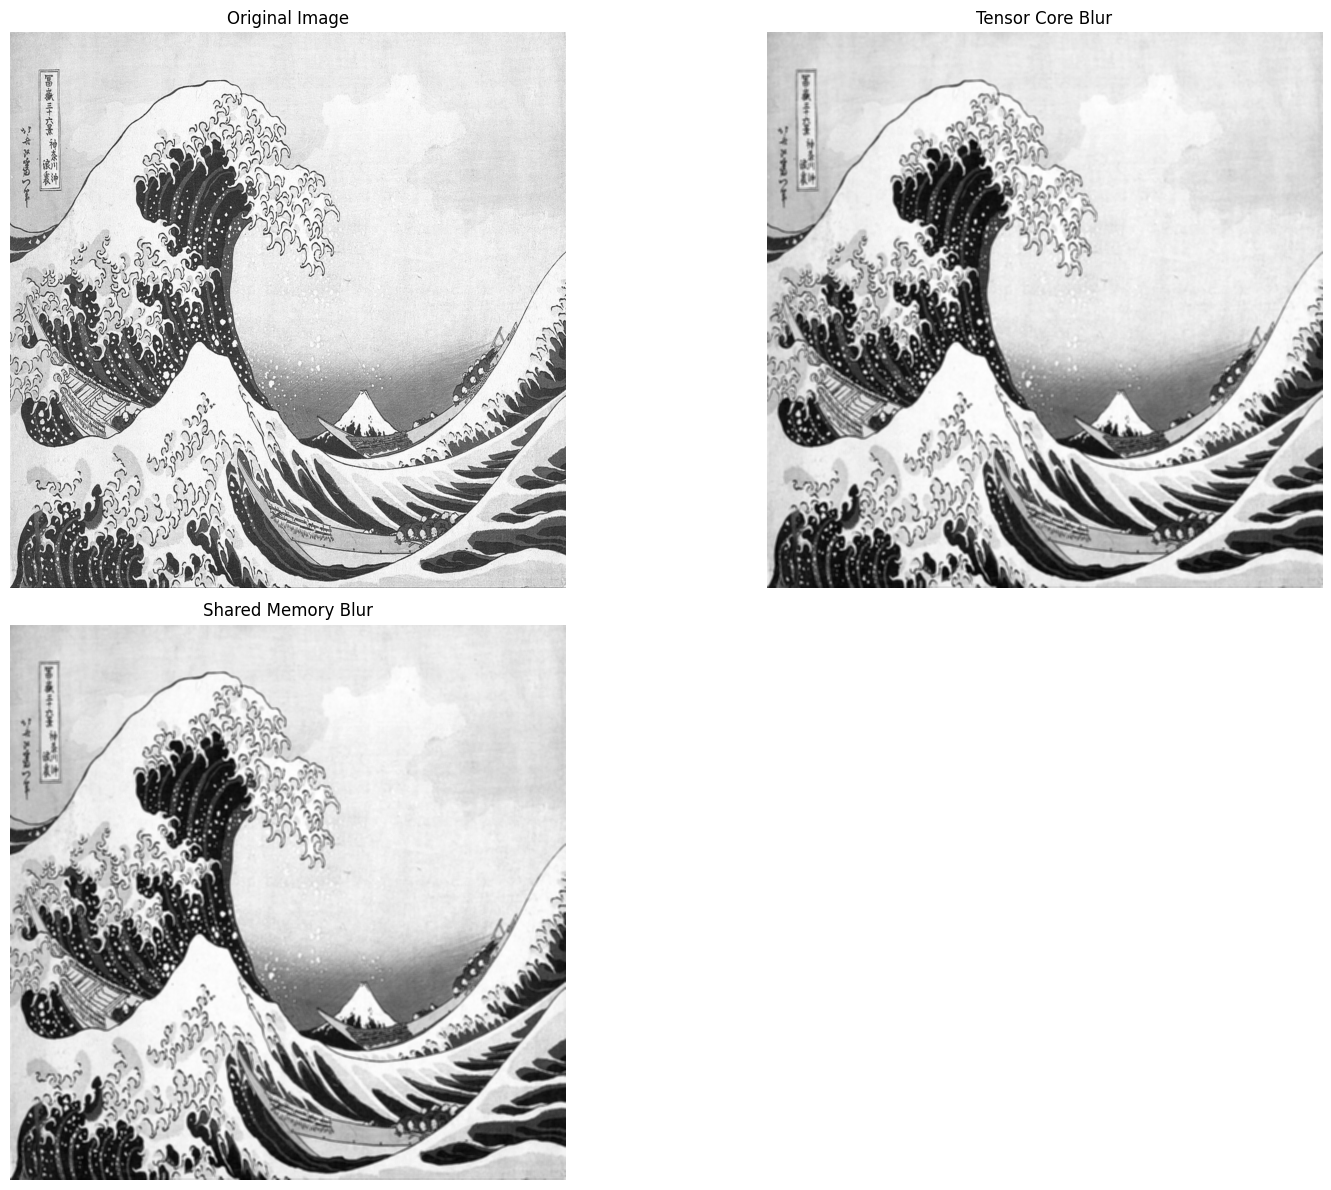


Running benchmarks...
Performing warm-up...

Benchmarking tensor core method...
Trial 1: 0.006839 seconds
Trial 2: 0.007065 seconds
Trial 3: 0.006993 seconds
Trial 4: 0.007528 seconds
Trial 5: 0.007365 seconds

Benchmarking shared memory method...
Trial 1: 0.000382 seconds
Trial 2: 0.000317 seconds
Trial 3: 0.000318 seconds
Trial 4: 0.000322 seconds
Trial 5: 0.000336 seconds

Results:
Tensor Core method: 0.007158s avg, 146.49 Mpixels/sec
Shared Memory method: 0.000335s avg, 3130.73 Mpixels/sec
Speedup: 21.37x

Mean absolute difference between tensor and shared: 0.00000003
 Blur Tensor Core resources cleaned up


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
from io import BytesIO
import cupy as cp
import time
from tensor_cuda_image4 import OptimizedImageOps

# Download a test image
def load_image(url, size=(1024, 1024)):
    """Load an image from URL and resize it."""
    print(f"Loading image from {url}")
    with urllib.request.urlopen(url) as response:
        img = Image.open(BytesIO(response.read()))
    
    # Resize and convert to grayscale
    img = img.resize(size).convert('L')
    return np.array(img, dtype=np.float64) / 255.0

# Simple NumPy implementation for comparison
def numpy_blur(image, kernel_size=3):
    """Apply blur using NumPy (CPU implementation)."""
    height, width = image.shape
    result = np.zeros_like(image)
    pad = kernel_size // 2
    
    # Create padded array
    padded = np.pad(image, pad, mode='reflect')
    
    # Apply blur kernel
    for y in range(height):
        for x in range(width):
            # Extract patch
            patch = padded[y:y+kernel_size, x:x+kernel_size]
            # Apply average blur
            result[y, x] = np.mean(patch)
    
    return result

# Main test function
def main():
    # Initialize the optimized blur operations
    blur_ops = OptimizedBlurOps()
    
    # Load a test image
    url = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/1200px-Tsunami_by_hokusai_19th_century.jpg"
    original_image = load_image(url)
    
    print(f"Original image shape: {original_image.shape}")
    
    # Parameters
    kernel_size = 5
    
    # Apply different blur methods
    print("\nApplying blur using Tensor Core method...")
    tensor_result = blur_ops.blur_tensor(original_image, kernel_size)
    
    print("\nApplying blur using Shared Memory method...")
    shared_result = blur_ops.blur_shared_memory(original_image, kernel_size)
    
    # For small images, also do NumPy comparison
    if original_image.size < 1024*1024:
        print("\nApplying blur using NumPy (CPU)...")
        start = time.time()
        numpy_result = numpy_blur(original_image, kernel_size)
        numpy_time = time.time() - start
        print(f"NumPy blur time: {numpy_time:.6f} seconds")
    else:
        numpy_result = None
        print("\nSkipping NumPy comparison for large image")
    
    # Display results
    plt.figure(figsize=(16, 12))
    
    plt.subplot(221)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(222)
    plt.imshow(tensor_result, cmap='gray')
    plt.title("Tensor Core Blur")
    plt.axis('off')
    
    plt.subplot(223)
    plt.imshow(shared_result, cmap='gray')
    plt.title("Shared Memory Blur")
    plt.axis('off')
    
    if numpy_result is not None:
        plt.subplot(224)
        plt.imshow(numpy_result, cmap='gray')
        plt.title("NumPy Blur (CPU)")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('blur_comparison.png')
    plt.show()
    
    # Run benchmarks
    print("\nRunning benchmarks...")
    results = blur_ops.benchmark(original_image, kernel_size, num_trials=5)
    
    # Compare results numerically
    diff_tensor_shared = np.abs(tensor_result - shared_result).mean()
    print(f"\nMean absolute difference between tensor and shared: {diff_tensor_shared:.8f}")
    
    if numpy_result is not None:
        diff_tensor_numpy = np.abs(tensor_result - numpy_result).mean()
        diff_shared_numpy = np.abs(shared_result - numpy_result).mean()
        print(f"Mean absolute difference between tensor and numpy: {diff_tensor_numpy:.8f}")
        print(f"Mean absolute difference between shared and numpy: {diff_shared_numpy:.8f}")

if __name__ == "__main__":
    main()

Loading image from https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/1200px-Tsunami_by_hokusai_19th_century.jpg
Image shape: (2048, 2048)
Initializing CUDA...
CUDA initialization complete
Function signatures configured
 Image Tensor operations initialized with CUDA streams
Image operations initialized

Applying operations...
 Image Tensor resources cleaned up
Saved results to image_operations_results.png


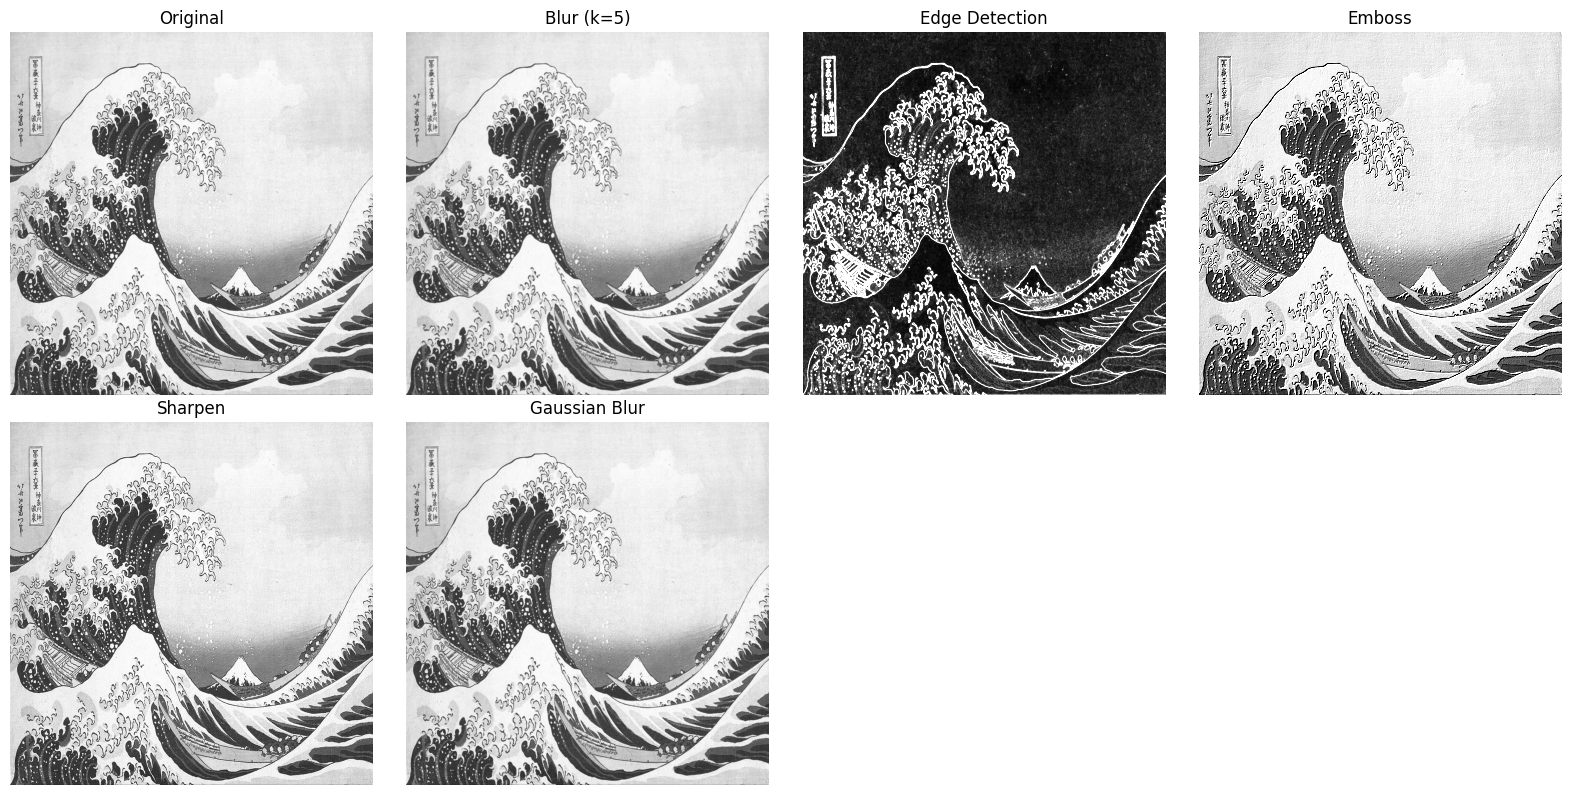

Initializing CUDA...
CUDA initialization complete
Function signatures configured
Image operations initialized

Running benchmarks...
 Image Tensor operations initialized with CUDA streams

Benchmark Results:
Operation  N-body Time (ms) CuPy Time (ms)   Speedup    N-body MPix/s    CuPy MPix/s      Tensor Time (ms) Tensor Speedup  Tensor MPix/s   
--------------------------------------------------------------------------------
blur       0.99             1.84             1.85       4215.51          2277.19         
edge       1.98             0.92             0.46       2117.75          4559.69          17.22            0.05            243.52          
emboss     0.51             0.35             0.69       8179.37          11843.40        
sharpen    0.69             0.29             0.43       6101.62          14221.65        


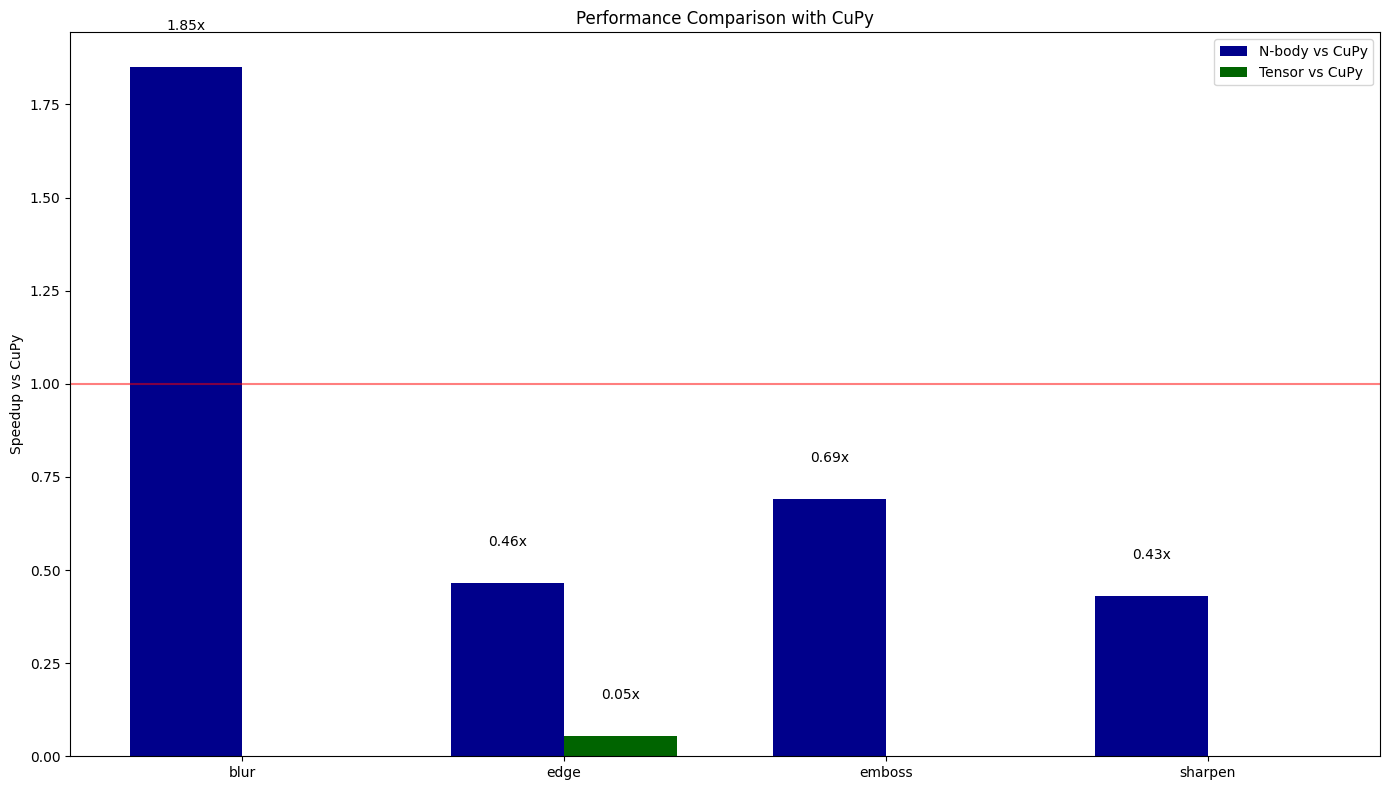

Initializing CUDA... Image Tensor resources cleaned up

CUDA initialization complete
Function signatures configured
Image operations initialized

Applying edge detection methods...
 Image Tensor operations initialized with CUDA streams
N-body shared memory edge detection: 19.25 ms
Tensor core edge detection: 35.66 ms
CuPy edge detection: 113.23 ms

Speedup - N-body vs CuPy: 5.88x
Speedup - Tensor vs CuPy: 3.18x
Speedup - Tensor vs N-body: 0.54x


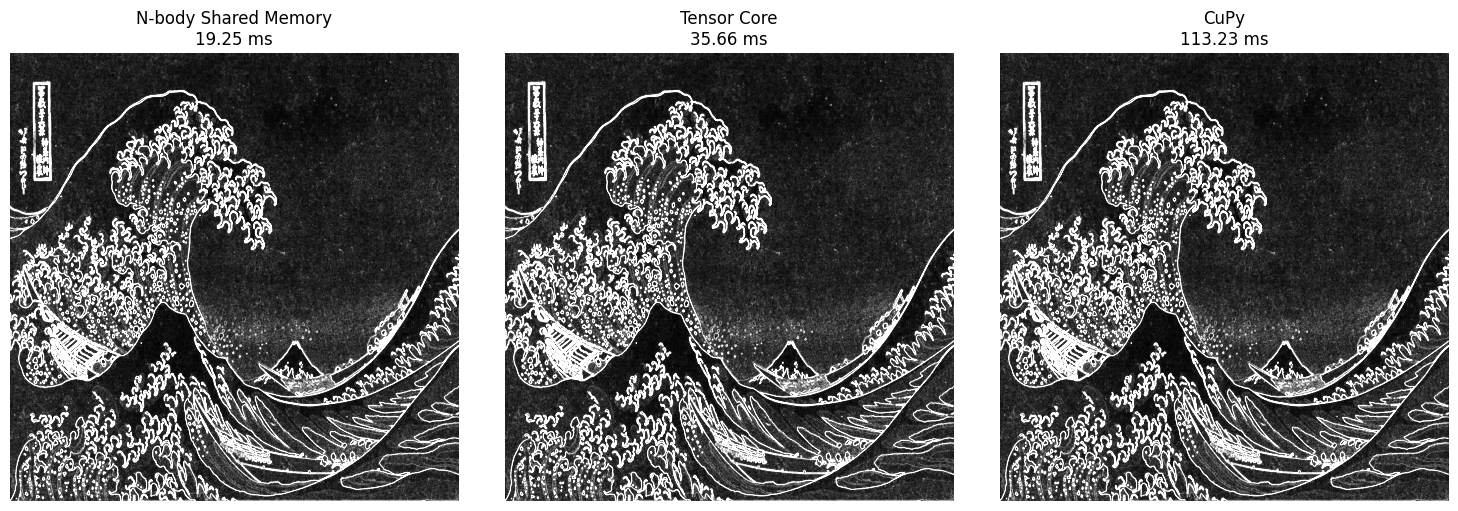


Mean absolute difference - N-body vs CuPy: 0.00030622
Mean absolute difference - Tensor vs N-body: 0.00000007
Mean absolute difference - Tensor vs CuPy: 0.00030629
 Image Tensor resources cleaned up


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
from io import BytesIO
import cupy as cp
import time
from tensor_cuda_image4 import OptimizedImageOps

# Download a test image
def load_image(url, size=(1024, 1024)):
    """Load an image from URL and resize it."""
    print(f"Loading image from {url}")
    with urllib.request.urlopen(url) as response:
        img = Image.open(BytesIO(response.read()))
    
    # Resize and convert to grayscale
    img = img.resize(size).convert('L')
    return np.array(img, dtype=np.float64) / 255.0

# Simple helper to display results
def display_results(images, titles, filename=None):
    """Display images in a grid with titles."""
    num_images = len(images)
    cols = min(4, num_images)
    rows = (num_images + cols - 1) // cols
    
    plt.figure(figsize=(cols * 4, rows * 4))
    
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray', vmin=0, vmax=1)
        plt.title(title)
        plt.axis('off')
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=150)
        print(f"Saved results to {filename}")
    
    plt.show()

# Demo function - showing basic operations
def demo_operations(image_size=1024):
    # Load a test image
    url = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/1200px-Tsunami_by_hokusai_19th_century.jpg"
    original_image = load_image(url, size=(image_size, image_size))
    
    print(f"Image shape: {original_image.shape}")
    
    # Initialize the optimized image operations
    ops = OptimizedImageOps()
    
    # Apply all operations
    print("\nApplying operations...")
    
    # Blur with kernel size 5
    blur_result = ops.blur(original_image, 5)
    
    # Edge detection
    edge_result = ops.edge_detection(original_image)
    
    # Emboss
    emboss_result = ops.emboss(original_image)
    
    # Sharpen
    sharpen_result = ops.sharpen(original_image)
    
    # Custom filter (Gaussian blur)
    gaussian_kernel = np.array([
        [1, 2, 1],
        [2, 4, 2],
        [1, 2, 1]
    ], dtype=np.float64) / 16.0
    
    gaussian_result = ops.custom_filter(original_image, gaussian_kernel)
    
    # Display results
    images = [original_image, blur_result, edge_result, emboss_result, sharpen_result, gaussian_result]
    titles = ["Original", "Blur (k=5)", "Edge Detection", "Emboss", "Sharpen", "Gaussian Blur"]
    
    display_results(images, titles, "image_operations_results.png")
    
    return ops, original_image  # Return for potential further use

def benchmark_compare(ops, image, operations=['blur', 'edge', 'emboss', 'sharpen'], num_trials=3):
    """Compare our optimized operations with CuPy implementations.

    Args:
        ops: OptimizedImageOps instance
        image: 2D numpy array
        operations: List of operations to benchmark
        num_trials: Number of trials for each benchmark

    Returns:
        Dictionary with benchmark results
    """
    # Convert to device array
    image_d = cp.asarray(image, dtype=cp.float64)
    height, width = image_d.shape

    results = {}

    # Define CuPy kernels for comparison
    cupy_kernels = {
        'blur': cp.ElementwiseKernel(
            'raw T input, int32 width, int32 height, int32 ksize',
            'T output',
            '''
            int x = i % width;
            int y = i / width;
            int half_ksize = ksize / 2;
            double sum = 0;
            int count = 0;

            for (int ky = -half_ksize; ky <= half_ksize; ky++) {
                int py = y + ky;
                if (py < 0) py = 0;
                if (py >= height) py = height - 1;

                for (int kx = -half_ksize; kx <= half_ksize; kx++) {
                    int px = x + kx;
                    if (px < 0) px = 0;
                    if (px >= width) px = width - 1;

                    sum += input[py * width + px];
                    count++;
                }
            }

            output = sum / count;
            ''',
            'blur_kernel'
        ),
        'edge': cp.ElementwiseKernel(
            'raw T input, int32 width, int32 height',
            'T output',
            '''
            int x = i % width;
            int y = i / width;

            if (x == 0 || x == width-1 || y == 0 || y == height-1) {
                output = 0;
                return;
            }

            double gx = -input[(y-1)*width + (x-1)] + input[(y-1)*width + (x+1)]
                    -2*input[y*width + (x-1)]     + 2*input[y*width + (x+1)]
                    -input[(y+1)*width + (x-1)]   + input[(y+1)*width + (x+1)];

            double gy = -input[(y-1)*width + (x-1)]  - 2*input[(y-1)*width + x]  - input[(y-1)*width + (x+1)]
                        +input[(y+1)*width + (x-1)]  + 2*input[(y+1)*width + x]  + input[(y+1)*width + (x+1)];

            output = sqrt(gx*gx + gy*gy);
            ''',
            'edge_kernel'
        ),
        'emboss': cp.ElementwiseKernel(
            'raw T input, int32 width, int32 height',
            'T output',
            '''
            int x = i % width;
            int y = i / width;

            if (x == 0 || x == width-1 || y == 0 || y == height-1) {
                output = input[i];
                return;
            }

            output = -2*input[(y-1)*width + (x-1)] - input[(y-1)*width + x]
                    -input[y*width + (x-1)]       + input[y*width + x]   + input[y*width + (x+1)]
                                                + input[(y+1)*width + x] + 2*input[(y+1)*width + (x+1)];

            // Scale to [0,1] range
            output = (output + 1) / 2;
            ''',
            'emboss_kernel'
        ),
        'sharpen': cp.ElementwiseKernel(
            'raw T input, int32 width, int32 height',
            'T output',
            '''
            int x = i % width;
            int y = i / width;

            if (x == 0 || x == width-1 || y == 0 || y == height-1) {
                output = input[i];
                return;
            }

            output = -input[(y-1)*width + x]
                    -input[y*width + (x-1)] + 5*input[y*width + x] - input[y*width + (x+1)]
                    -input[(y+1)*width + x];

            // Clamp to [0,1] range
            if (output < 0) output = 0;
            if (output > 1) output = 1;
            ''',
            'sharpen_kernel'
        )
    }

    # Benchmarking loop
    for op in operations:
        results[op] = {}

        # Warm-up
        if op == 'blur':
            _ = ops.blur(image_d, 5)
            cupy_output = cp.zeros_like(image_d)
            cupy_kernels[op](image_d, width, height, 5, cupy_output)
        elif op == 'edge':
            _ = ops.edge_detection(image_d)  # N-body shared memory version
            try:
                _ = ops.edge_detection_tensor(image_d)  # Tensor core version
            except AttributeError:
                print("Tensor core edge detection not available")
            cupy_output = cp.zeros_like(image_d)
            cupy_kernels[op](image_d, width, height, cupy_output)
        elif op == 'emboss':
            _ = ops.emboss(image_d)
            cupy_output = cp.zeros_like(image_d)
            cupy_kernels[op](image_d, width, height, cupy_output)
        elif op == 'sharpen':
            _ = ops.sharpen(image_d)
            cupy_output = cp.zeros_like(image_d)
            cupy_kernels[op](image_d, width, height, cupy_output)

        # Benchmark our N-body optimized implementation
        nbody_times = []
        for _ in range(num_trials):
            cp.cuda.Stream.null.synchronize()
            start = time.time()

            if op == 'blur':
                _ = ops.blur(image_d, 5)
            elif op == 'edge':
                _ = ops.edge_detection(image_d)
            elif op == 'emboss':
                _ = ops.emboss(image_d)
            elif op == 'sharpen':
                _ = ops.sharpen(image_d)

            cp.cuda.Stream.null.synchronize()
            nbody_times.append(time.time() - start)

        # For edge detection, also benchmark tensor core version if available
        if op == 'edge' and hasattr(ops, 'edge_detection_tensor'):
            tensor_times = []
            for _ in range(num_trials):
                cp.cuda.Stream.null.synchronize()
                start = time.time()
                _ = ops.edge_detection_tensor(image_d)
                cp.cuda.Stream.null.synchronize()
                tensor_times.append(time.time() - start)

        # Benchmark CuPy implementation
        cupy_times = []
        for _ in range(num_trials):
            cupy_output = cp.zeros_like(image_d)
            cp.cuda.Stream.null.synchronize()
            start = time.time()

            if op == 'blur':
                cupy_kernels[op](image_d, width, height, 5, cupy_output)
            else:
                cupy_kernels[op](image_d, width, height, cupy_output)

            cp.cuda.Stream.null.synchronize()
            cupy_times.append(time.time() - start)

        # Calculate statistics
        nbody_avg = sum(nbody_times) / num_trials
        cupy_avg = sum(cupy_times) / num_trials
        nbody_mpix = (height * width) / (nbody_avg * 1000000.0)
        cupy_mpix = (height * width) / (cupy_avg * 1000000.0)
        nbody_speedup = cupy_avg / nbody_avg

        results[op] = {
            'nbody_avg_time': nbody_avg,
            'cupy_avg_time': cupy_avg,
            'nbody_mpix_per_second': nbody_mpix,
            'cupy_mpix_per_second': cupy_mpix,
            'speedup': nbody_speedup
        }

        # Add tensor core results for edge detection if available
        if op == 'edge' and hasattr(ops, 'edge_detection_tensor'):
            tensor_avg = sum(tensor_times) / num_trials
            tensor_mpix = (height * width) / (tensor_avg * 1000000.0)
            tensor_speedup = cupy_avg / tensor_avg

            results[op]['tensor_avg_time'] = tensor_avg
            results[op]['tensor_mpix_per_second'] = tensor_mpix
            results[op]['tensor_speedup'] = tensor_speedup

    return results

# Benchmark function
def run_benchmarks(image, num_trials=5):
    # Initialize the optimized image operations
    ops = OptimizedImageOps()
    
    print("\nRunning benchmarks...")
    results = benchmark_compare(
        ops,  # Pass the ops instance
        image, 
        operations=['blur', 'edge', 'emboss', 'sharpen'], 
        num_trials=num_trials
    )
    
    # Display benchmark results
    print("\nBenchmark Results:")
    print("=" * 80)
    header_line = f"{'Operation':<10} {'N-body Time (ms)':<16} {'CuPy Time (ms)':<16} {'Speedup':<10} {'N-body MPix/s':<16} {'CuPy MPix/s':<16}"
    
    # Check if tensor results are available for any operation
    has_tensor_results = any('tensor_avg_time' in res for res in results.values())
    if has_tensor_results:
        header_line += f" {'Tensor Time (ms)':<16} {'Tensor Speedup':<15} {'Tensor MPix/s':<16}"
    
    print(header_line)
    print("-" * 80)
    
    for op, res in results.items():
        line = f"{op:<10} {res['nbody_avg_time']*1000:<16.2f} {res['cupy_avg_time']*1000:<16.2f} {res['speedup']:<10.2f} {res['nbody_mpix_per_second']:<16.2f} {res['cupy_mpix_per_second']:<16.2f}"
        
        # Add tensor results if available
        if 'tensor_avg_time' in res:
            line += f" {res['tensor_avg_time']*1000:<16.2f} {res['tensor_speedup']:<15.2f} {res['tensor_mpix_per_second']:<16.2f}"
        
        print(line)
    
    print("=" * 80)
    
    # Create bar chart of speedups
    plt.figure(figsize=(14, 8))
    
    ops_list = list(results.keys())
    nbody_speedups = [results[op]['speedup'] for op in ops_list]
    
    # Data for bar chart
    bar_data = []
    bar_labels = []
    
    # Always include N-body speedups
    bar_data.append(nbody_speedups)
    bar_labels.append('N-body vs CuPy')
    
    # Check if any tensor results exist
    if has_tensor_results:
        tensor_speedups = []
        for op in ops_list:
            if 'tensor_speedup' in results[op]:
                tensor_speedups.append(results[op]['tensor_speedup'])
            else:
                tensor_speedups.append(0)  # No speedup for operations without tensor implementation
        
        bar_data.append(tensor_speedups)
        bar_labels.append('Tensor vs CuPy')
    
    # Set width of bars
    bar_width = 0.35
    r = np.arange(len(ops_list))
    
    # Create bars
    if len(bar_data) > 1:
        plt.bar(r - bar_width/2, bar_data[0], width=bar_width, label=bar_labels[0], color='darkblue')
        plt.bar(r + bar_width/2, bar_data[1], width=bar_width, label=bar_labels[1], color='darkgreen')
    else:
        plt.bar(r, bar_data[0], width=bar_width, label=bar_labels[0], color='darkblue')
    
    plt.axhline(y=1.0, color='r', linestyle='-', alpha=0.5)
    plt.ylabel('Speedup vs CuPy')
    plt.title('Performance Comparison with CuPy')
    plt.xticks(r, ops_list)
    plt.legend()
    plt.ylim(bottom=0)
    
    # Add value labels on top of bars
    for i, data in enumerate(bar_data):
        x_offset = -bar_width/2 if i == 0 and len(bar_data) > 1 else (bar_width/2 if i == 1 else 0)
        for j, v in enumerate(data):
            if v > 0:  # Only add label if there's a speedup
                plt.text(j + x_offset, v + 0.1, f"{v:.2f}x", ha='center')
    
    plt.tight_layout()
    plt.savefig("benchmark_results.png", dpi=150)
    plt.show()
    
    return results

# Compare different edge detection methods
def compare_edge_detection(image):
    """Compare different edge detection implementations.
    
    Args:
        image: 2D numpy array
        
    Returns:
        Dictionary with times and outputs
    """
    # Initialize the optimized image operations
    ops = OptimizedImageOps()
    
    # Apply different edge detection methods
    print("\nApplying edge detection methods...")
    
    # N-body shared memory version
    start = time.time()
    nbody_result = ops.edge_detection(image)
    nbody_time = time.time() - start
    print(f"N-body shared memory edge detection: {nbody_time*1000:.2f} ms")
    
    # Tensor core version if available
    tensor_result = None
    tensor_time = 0
    
    if hasattr(ops, 'edge_detection_tensor'):
        start = time.time()
        tensor_result = ops.edge_detection_tensor(image)
        tensor_time = time.time() - start
        print(f"Tensor core edge detection: {tensor_time*1000:.2f} ms")
    else:
        print("Tensor core edge detection not available")
    
    # CuPy version (element-wise kernel)
    image_d = cp.asarray(image, dtype=cp.float64)
    cupy_result = cp.zeros_like(image_d)
    
    # Define CuPy kernel for edge detection
    edge_kernel = cp.ElementwiseKernel(
        'raw T input, int32 width, int32 height',
        'T output',
        '''
        int x = i % width;
        int y = i / width;
        
        if (x == 0 || x == width-1 || y == 0 || y == height-1) {
            output = 0;
            return;
        }
        
        double gx = -input[(y-1)*width + (x-1)] + input[(y-1)*width + (x+1)]
                   -2*input[y*width + (x-1)]     + 2*input[y*width + (x+1)]
                   -input[(y+1)*width + (x-1)]   + input[(y+1)*width + (x+1)];
        
        double gy = -input[(y-1)*width + (x-1)]  - 2*input[(y-1)*width + x]  - input[(y-1)*width + (x+1)]
                    +input[(y+1)*width + (x-1)]  + 2*input[(y+1)*width + x]  + input[(y+1)*width + (x+1)];
        
        output = sqrt(gx*gx + gy*gy);
        ''',
        'edge_kernel'
    )
    
    # Apply CuPy edge detection
    height, width = image_d.shape
    start = time.time()
    edge_kernel(image_d, width, height, cupy_result)
    cupy_time = time.time() - start
    print(f"CuPy edge detection: {cupy_time*1000:.2f} ms")
    
    # Calculate speedups
    nbody_vs_cupy = cupy_time / nbody_time
    print(f"\nSpeedup - N-body vs CuPy: {nbody_vs_cupy:.2f}x")
    
    if tensor_result is not None:
        tensor_vs_cupy = cupy_time / tensor_time
        tensor_vs_nbody = nbody_time / tensor_time
        print(f"Speedup - Tensor vs CuPy: {tensor_vs_cupy:.2f}x")
        print(f"Speedup - Tensor vs N-body: {tensor_vs_nbody:.2f}x")
    
    # Display results
    plt.figure(figsize=(15, 5))
    
    if tensor_result is not None:
        plt.subplot(131)
    else:
        plt.subplot(121)
    
    plt.imshow(nbody_result, cmap='gray', vmin=0, vmax=1)
    plt.title(f"N-body Shared Memory\n{nbody_time*1000:.2f} ms")
    plt.axis('off')
    
    if tensor_result is not None:
        plt.subplot(132)
        plt.imshow(tensor_result, cmap='gray', vmin=0, vmax=1)
        plt.title(f"Tensor Core\n{tensor_time*1000:.2f} ms")
        plt.axis('off')
        
        plt.subplot(133)
    else:
        plt.subplot(122)
    
    plt.imshow(cp.asnumpy(cupy_result), cmap='gray', vmin=0, vmax=1)
    plt.title(f"CuPy\n{cupy_time*1000:.2f} ms")
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig("edge_detection_comparison.png", dpi=150)
    plt.show()
    
    # Compare difference between methods
    diff_nbody_cupy = np.abs(nbody_result - cp.asnumpy(cupy_result)).mean()
    print(f"\nMean absolute difference - N-body vs CuPy: {diff_nbody_cupy:.8f}")
    
    if tensor_result is not None:
        diff_tensor_nbody = np.abs(tensor_result - nbody_result).mean()
        diff_tensor_cupy = np.abs(tensor_result - cp.asnumpy(cupy_result)).mean()
        print(f"Mean absolute difference - Tensor vs N-body: {diff_tensor_nbody:.8f}")
        print(f"Mean absolute difference - Tensor vs CuPy: {diff_tensor_cupy:.8f}")
    
    return {
        'nbody_result': nbody_result,
        'tensor_result': tensor_result if tensor_result is not None else None,
        'cupy_result': cp.asnumpy(cupy_result),
        'nbody_time': nbody_time,
        'tensor_time': tensor_time if tensor_result is not None else None,
        'cupy_time': cupy_time
    }

# Example usage in Jupyter notebook:
if __name__ == "__main__":
    # 1. Run demo_operations() to see all operations in action
    ops, image = demo_operations(image_size=2048)
    
    # 2. Run benchmarks
    results = run_benchmarks(image, num_trials=5)
    
    # 3. Compare edge detection methods specifically
    edge_results = compare_edge_detection(image)